In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming filtered_data is the DataFrame from the previous notebook
%store -r filtered_data
# Identify categorical and numerical columns
categorical_columns = filtered_data.select_dtypes(include=['object']).columns
numerical_columns = filtered_data.select_dtypes(include=['int', 'float']).columns

# Manual one-hot encoding using pandas get_dummies
encoded_categorical_df = pd.get_dummies(filtered_data[categorical_columns])

# Concatenation of encoded categorical and scaled numerical DataFrames
processed_data = pd.concat([encoded_categorical_df, filtered_data[numerical_columns]], axis=1)

# skipping min max sxcaling on decision tree models


In [2]:
print("processed_data: \n",processed_data.describe())
      
      
X = processed_data.drop(['risk','Sex_M','Smoking_yes','Heart rate data used_0.0'], axis=1)
y = processed_data['risk']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

processed_data: 
               Age         BMI  MET (activity level)        risk
count  209.000000  209.000000            209.000000  209.000000
mean    39.820818   26.493015             13.177336    0.582553
std      9.434708    5.090887             10.783680    0.367613
min     22.999316   17.226562              0.145333    0.001500
25%     31.841422   23.146952              5.221824    0.320000
50%     39.491456   25.468471             10.628157    0.488300
75%     46.974710   28.731747             19.654733    0.772300
max     60.645249   42.201019             58.289505    2.439100


#
Random Forest was tested but selected xgb from here 

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor 
import seaborn as sns

models = {
   # 'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor() ,
}

hyperparams = {
   # 'Random Forest': {'n_estimators': [25, 50], 'max_depth': [3, 5,7], 'min_samples_split': [ 5, 10]},  
    'XGBoost': {'n_estimators': [25,50], 'max_depth': [3, 5 ],'learning_rate': [0.05, 0.1, 0.3], 'colsample_bytree': [0.6, 0.8, 1.0],
        'min_child_weight' : [5, 10]}
}


# Perform hyperparameter tuning for each model
results = {}
model_scores={}
for model_name, model in models.items():
    grid_search = GridSearchCV(model, hyperparams[model_name], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    print(f"Scores for {model_name}:")
    results = grid_search.cv_results_
    for mean_score, params in zip(results['mean_test_score'], results['params']):
        r2_scores = 1 - (mean_score * -1) / np.var(y_train)  # Calculate R2 score
        #print(f"Hyperparameters: {params} R2 score: {r2_scores}")
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_scores[model_name] = {'MSE': mse, 'R2': r2 , 'params' : best_params}
    

# Print the MSE and R2 for each model
for model, scores in model_scores.items():
    print(f"Model: {model} Params: {scores['params']}, MSE: {scores['MSE']}, R2: {scores['R2']}")
xgb=best_model

Scores for XGBoost:
Model: XGBoost Params: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50}, MSE: 0.022451924343361202, R2: 0.8732270066071589


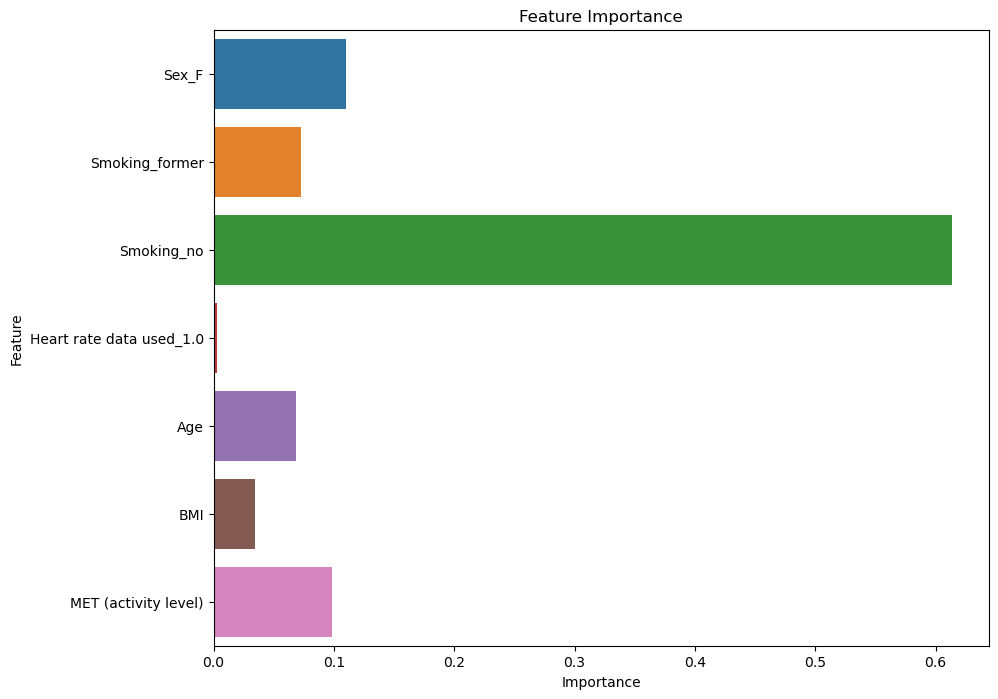

In [4]:
# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x=xgb.feature_importances_, y=X.columns)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


#

Post the testing its better to use xgboost ; the randomForest regressor tested had below ouput

#
Scores for Random Forest:
Hyperparameters: {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 25} R2 score: 0.6428135296832678
Hyperparameters: {'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50} R2 score: 0.6577670146503856
Hyperparameters: {'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 25} R2 score: 0.6393258515221707
Hyperparameters: {'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 50} R2 score: 0.6487221314410432
Hyperparameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 25} R2 score: 0.7433834171940997
Hyperparameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50} R2 score: 0.7473193549440551
Hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 25} R2 score: 0.72780070310808
Hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50} R2 score: 0.7183823513128622
Hyperparameters: {'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 25} R2 score: 0.7504822894280114
Hyperparameters: {'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 50} R2 score: 0.7354680215281864
Hyperparameters: {'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 25} R2 score: 0.7277075350304242
Hyperparameters: {'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 50} R2 score: 0.7231095621670296

In [36]:
#xgb.plot_tree(best_model, num_trees=0)
#plt.show()

#
Scores for XGBoost:
Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 25} R2 score: 0.6170731778025964
Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 50} R2 score: 0.75015043442176
Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 25} R2 score: 0.6098902515130863
Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 50} R2 score: 0.7132494612753324
Hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 25} R2 score: 0.664155783811496
Hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50} R2 score: 0.7939389981310209
Hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 25} R2 score: 0.6412659206536728
Hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 50} R2 score: 0.7514867286585066
Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 25} R2 score: 0.7491942496375059
Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 50} R2 score: 0.8210193075901596
Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 25} R2 score: 0.7176151762243212
Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 50} R2 score: 0.7993252732022246
Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 25} R2 score: 0.7910508022939394
Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50} R2 score: 0.8306228618864704
Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 25} R2 score: 0.7529977060090798
Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 50} R2 score: 0.8156076797681768
Hyperparameters: {'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 25} R2 score: 0.8524880755005659
# 
training fit 
Hyperparameters: {'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 50} R2 score: 0.8681045125796161


Hyperparameters: {'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 25} R2 score: 0.8245294626469748
Hyperparameters: {'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 50} R2 score: 0.8528912035528716
Hyperparameters: {'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 25} R2 score: 0.840794547151354
Hyperparameters: {'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50} R2 score: 0.8446903409142934
Hyperparameters: {'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 25} R2 score: 0.8364289254578084
Hyperparameters: {'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 50} R2 score: 0.8468798304813102